In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import glob
import sys
from scipy import io
import math
from skimage import transform
import random
import keras
from sklearn import preprocessing
import tqdm

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# GLOBALS

In [3]:
POET_DIR = "D:/data/POETdataset/"
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE_PERC = 0.2 # to width
PATCH_SIZE = 48
HALF_PATCH = PATCH_SIZE//2
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
# MAX_GAZE_POINTS = 3 # TEMPORARY
# MIN_GAZE_POINTS = 3
VGG_NR_FEATURES = 512
BATCH_SIZE = 50
USE_FASTEST_USER = False
os.chdir(POET_DIR)

In [4]:
os.chdir(POET_DIR)

# PATCH EXTRACTION 

In [5]:
classes = [a.split("_")[1].split(".mat")[0] for a in glob.glob("etData/*")]
idx2class = {i:c for i, c in enumerate(classes)}
class2idx = {c:i for i, c in enumerate(classes)}

In [6]:
def fixation_within_image(fx, fy, dims):
#   print(dims)
  if fx < 0:
    return False
  if fx > dims[1]:
    return False
  if fy < 0:
    return False
  if fy > dims[0]:
    return False

  return True

In [7]:
def get_avg_fixations(fixR, fixL, dims):
    # ger average of fixations between right and left eye
    fix = []
    for i in range(len(fixR)):
        fR = fixR[i]
        fL = fixL[i]
        fx = None
        fy = None
        # no fixations outside
        if np.isnan(fR[0]):
            fx = fL[0]
            fy = fL[1]
        elif np.isnan(fL[0]):
            fx = fR[0]
            fy = fR[1]
        else:
            fx = np.mean([fR[0],fL[0]])
            fy = np.mean([fR[1],fL[1]])
        if fixation_within_image(fx, fy, dims):
            fix.append([fx,fy])

    fix = np.array(fix)
    return fix

In [8]:
class_matrices = {}

In [9]:
def get_fixations(filename, classname, dims):
    filename = filename.split("%s_" %classname)[1]
    filename = filename.split('.')[0]
    if classname not in class_matrices.keys():
        c_instances = io.loadmat(os.path.join(POET_DIR,'etData','etData_%s.mat' %classname), squeeze_me=True)['etData']
        class_matrices[classname] = c_instances
    else:
        c_instances = class_matrices[classname]

    for i in c_instances:
        if filename == i['filename']:
            # fastest user or slowest user
            if USE_FASTEST_USER:
                user_index = np.argmin(i['rt'])
            else:
                user_index = np.argmax(i['rt'])
            fixR = i['fixations'][user_index]['imgCoord']['fixR'].tolist()['pos'].tolist()
            fixL = i['fixations'][user_index]['imgCoord']['fixL'].tolist()['pos'].tolist()
            if len(fixL.shape) < 2:
                return None
            fix = get_avg_fixations(fixR, fixL, dims)
            return fix


In [10]:
def gen_patches(filename, classname):
    img_src = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(filename)
    )
    patch_size_image = int(img_src.shape[0] * PATCH_SIZE_PERC)
    if patch_size_image % 2 == 1:
        patch_size_image += 1
    half_patch_size_image = patch_size_image//2

    img = np.zeros((img_src.shape[0]+patch_size_image, img_src.shape[1]+patch_size_image, 3), dtype=float)
    img[half_patch_size_image:half_patch_size_image+img_src.shape[0],half_patch_size_image:img_src.shape[1]+half_patch_size_image] = img_src

    fix = get_fixations(filename, classname, (img_src.shape[0], img_src.shape[1]))
    if fix is None:
        return None

    patches = []

    for i, f in enumerate(fix):
        fx = math.floor(f[0]) + half_patch_size_image # to account for paddings
        fy = math.floor(f[1]) + half_patch_size_image
        p = img[fy-half_patch_size_image:fy+half_patch_size_image,fx-half_patch_size_image:fx+half_patch_size_image]
        p = transform.resize(p, (PATCH_SIZE, PATCH_SIZE, 3))
        assert p.shape==(PATCH_SIZE, PATCH_SIZE, 3), 'file "%s" of class %s has a patch of shape %s' %(filename, classname, p.shape)
        patches.append(p)
        
    return patches

# STORE ALL PATCHES

In [11]:
filenames = glob.glob(os.path.join(pascal_images, "*"))

In [12]:
total_instances = len(filenames)

In [13]:
all_patches_list = []
all_labels_list = []

dropped_list = []
ids = []
max_nr_of_fixations = 0
for i, fn in enumerate(tqdm.tqdm(filenames)):
    for cname in classes:
        if cname in fn:
            patches = gen_patches(fn, cname)
            if patches is not None and len(patches)>0:
                if len(patches) > max_nr_of_fixations:
                    max_nr_of_fixations = len(patches)
                all_patches_list.append(patches)
                all_labels_list.append(class2idx[cname])
                ids.append(fn)
            else:
                dropped_list.append(fn)

  0%|                                                                                                                                                                                                        | 0/6270 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6270/6270 [01:01<00:00, 102.68it/s]


# Pad list of patches with zeros up until max

mean nr of fixations =  2.6437712619471894


(array([4.170e+02, 2.500e+03, 2.379e+03, 6.750e+02, 0.000e+00, 1.630e+02,
        2.700e+01, 9.000e+00, 1.000e+00, 2.000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

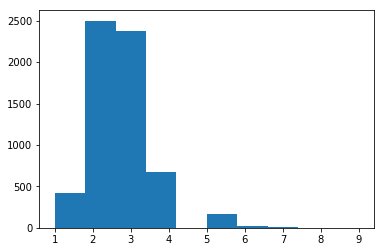

In [14]:
nr_of_fixations = [len(item) for item in all_patches_list]
print('mean nr of fixations = ', np.mean(nr_of_fixations))
plt.hist(nr_of_fixations)


### We choose max_nr_fixations = 5

In [15]:
MAX_PATCHES = 5

for i in range(len(all_patches_list)):
    entry = np.array(all_patches_list[i])
    if entry.shape[0] < MAX_PATCHES:
        nr_extra = MAX_PATCHES - entry.shape[0]
        empty_patches = np.zeros((nr_extra, PATCH_SIZE, PATCH_SIZE, 3))
        all_patches_list[i] = np.concatenate([empty_patches, entry])
    if entry.shape[0] > MAX_PATCHES:
        entry = entry[:5]
        entry = np.array(entry)
        all_patches_list[i] = entry
    all_patches_list[i] = np.array(all_patches_list[i])
        

In [16]:
all_patches_list = np.array(all_patches_list)

In [17]:
all_patches_list.shape

(6173, 5, 32, 32, 3)

# Storing

In [18]:
all_labels_list = np.array(all_labels_list)
ids = np.array(ids)

In [19]:
len(dropped_list) + len(all_labels_list)

6270

In [20]:
def save_data(all_labels_list, all_patches_list, ids, dropped_list):
    elems = [
        ('all_labels_list', all_labels_list),
        ('all_patches_list', all_patches_list),
        ('dropped_list', dropped_list), 
        ('ids',ids)
            ]
    if USE_FASTEST_USER:
        for e in elems:
            loc = "%s_fastest" %e[0]
            print('saving to', loc)
            np.save(loc, e[1])
            
    else:
        for e in elems:
            loc = "%s_slowest" %e[0]
            print('saving to', loc)
            np.save(loc, e[1])
            
    with open("data_note.txt", 'w') as f:
        f.writelines("perc: %s\npatch_size: %s" %(PATCH_SIZE_PERC, PATCH_SIZE))
        

In [21]:
save_data(all_labels_list, all_patches_list, ids, dropped_list)

saving to all_labels_list_fastest
saving to all_patches_list_fastest
saving to dropped_list_fastest
saving to ids_fastest


# Load data

In [18]:
all_labels_list = np.load('all_labels_list.npy')

In [19]:
all_patches_list = np.load("all_patches_list.npy")

In [20]:
ids = np.load("all_patches_ids.npy")

# Debugging

D:/data/POETdataset/PascalImages\cow_2011_000784.jpg


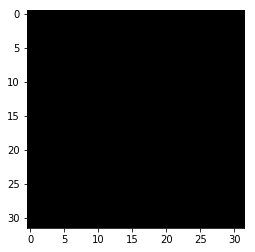

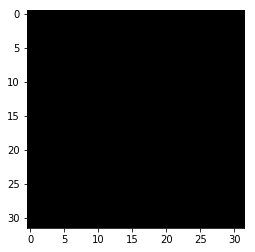

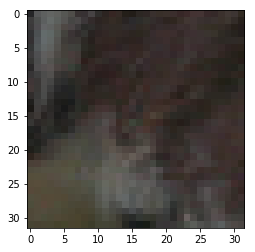

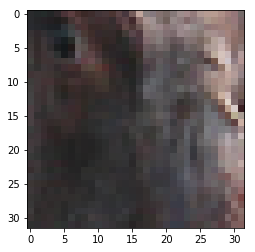

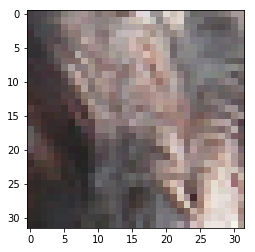

0.0 255.0


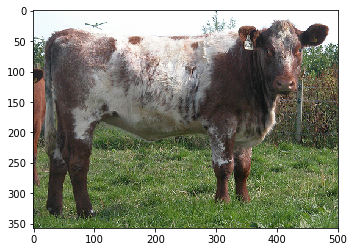

In [25]:
someid = 3000

print(ids[someid])

for i in range(len(all_patches_list[someid])):
    plt.imshow(all_patches_list[someid][i]/255)
    plt.show()

img = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(ids[someid])
    )

print(img.min(), img.max())

plt.imshow(img/255, cmap='gray')
plt.show()

D:/data/POETdataset/PascalImages\cow_2011_000784.jpg cow
[[283.   174.45]
 [396.05  80.75]
 [404.4   65.  ]]


(283, 80)

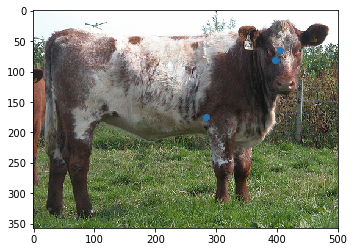

In [30]:
print(ids[someid], idx2class[all_labels_list[someid]])
fix = get_fixations(os.path.abspath(ids[someid]), idx2class[all_labels_list[someid]], (img.shape[0],img.shape[1]))
print(fix)
plt.imshow(img/255)
plt.scatter(fix[:,0], fix[:,1])

fx = int(fix[:,0][0])
fy = int(fix[:,1][1])
fx, fy

# plt.imshow(img[fy-64:fy+64,fx-64:fx+64]/255)

# Mean response times per class

In [21]:
for cname in classes:
    mat = io.loadmat(os.path.join(POET_DIR,'etData','etData_%s.mat' %cname), squeeze_me=True)['etData']
    print(cname, " : ", "%.4f" %np.mean(np.concatenate(mat[:]['rt'])))

aeroplane  :  0.8603
bicycle  :  0.8722
boat  :  0.9471
cat  :  0.7861
cow  :  1.0892
diningtable  :  0.8571
dog  :  0.8112
horse  :  0.9940
motorbike  :  0.8421
sofa  :  0.8390
